In [47]:
import lzma
import re
from collections import defaultdict
from itertools import chain
from pathlib import Path
from string import ascii_uppercase

import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from natsort import natsorted
from readpaf import parse_paf
from tqdm.notebook import tqdm

In [2]:
def get_group(file, pattern, default="unknown"):
    group = re.search(pattern, file.name)
    if group is not None:
        group = group.group(1)
    else:
        group = default

    return group

In [3]:
def filter_paf_df(df):
    df["map_start"] = np.where(
        df["strand"].eq("+"), df["target_start"], df["target_end"]
    )
    df = df.loc[
        df["mapping_quality"].gt(20)
        & df["tp"].eq("tp:A:P")
        & ~df["query_name"].duplicated()
    ]
    return df


def read_paf_file(f: Path):
    f = str(f)
    df = filter_paf_df(
        pd.read_csv(
            f,
            sep="\t",
            header=None,
            usecols=list(range(13)),
            names=[
                "query_name",
                "query_length",
                "query_start",
                "qend",
                "strand",
                "target_name",
                "target_length",
                "target_start",
                "target_end",
                "match",
                "block_len",
                "mapping_quality",
                "tp",
            ],
        )
    )
    return df

In [4]:
def paf_to_targets_dict(paf_df, remove=None, sort=True):
    """Take a PAF DataFrame with columns `target_name'
    and `target_length' and return an ordered dict of
    targets and their lengths.
    """
    remove = [] if remove is None else remove
    remove = [remove] if isinstance(remove, str) else remove
    chrs = dict(
        paf_df[["target_name", "target_length"]]
        .drop_duplicates(keep="first")
        .itertuples(index=False)
    )
    for chrom in remove:
        _ = chrs.pop(chrom, 0)
    if sort:
        chrom_order = natsorted(chrs.keys())
        chrs = dict(sorted(chrs.items(), key=lambda t: chrom_order.index(t[0])))
    return chrs

In [79]:
def add_panel_label(
    letter: str,
    text_font_dict: dict,
    axy,
    x_offset: float = -0.03,
    y_offset: float = 1.06,
) -> None:
    """
    Add the panel label (ABC) to the first axes in the Subplots
    """
    axy.text(
        x_offset,
        y_offset,
        letter,
        horizontalalignment="center",
        verticalalignment="center",
        fontdict=text_font_dict,
        transform=axy.transAxes,
    )

This might take a while, there's a lot of data

In [6]:
files = defaultdict(list)
# for f in Path("chunked_pafs").rglob("*.paf"):
#     print(f)
#     group = get_group(f, r"^(.*)_")
#     files[group].append(read_paf_file(f))
for f in Path(".").rglob("*.paf"):
    print(f)
    group = get_group(f, r"(barcode\d{2})")
    files[group].append(read_paf_file(f))

all_barcode06.sequenced.fastq.paf
all_barcode05.sequenced.fastq.paf
all_barcode05.unblocked.fastq.paf
all_barcode06.unblocked.fastq.paf
all_barcode07.unblocked.fastq.paf
all_barcode07.sequenced.fastq.paf
chunked_pafs/barcode01_01.paf
chunked_pafs/barcode02_02.paf
chunked_pafs/barcode03_01.paf
chunked_pafs/barcode02_01.paf
chunked_pafs/barcode02_00.paf
chunked_pafs/barcode01_02.paf
chunked_pafs/barcode03_00.paf
chunked_pafs/barcode03_04.paf
chunked_pafs/barcode02_04.paf
chunked_pafs/barcode03_02.paf
chunked_pafs/barcode01_00.paf
chunked_pafs/barcode02_05.paf
chunked_pafs/barcode02_03.paf
chunked_pafs/barcode01_03.paf
chunked_pafs/barcode03_03.paf


In [7]:
files = {f: pd.concat(dfs) for f, dfs in files.items()}

In [8]:
order = ("barcode01", "barcode05", "barcode02", "barcode06", "barcode03", "barcode07")
# Laxy reordering of dictionary to get like for like sample comparisons grid vs, prom
files = {barcode: files[barcode] for barcode in order}

In [9]:
files.keys()

dict_keys(['barcode01', 'barcode05', 'barcode02', 'barcode06', 'barcode03', 'barcode07'])

In [11]:
# Original height ratios
a = [1, 1, 1.21, 1, 1.21]

# Calculate total height and proportions
sum_a = sum(a)
prop_3 = a[2] / sum_a
prop_5 = a[4] / sum_a

# Calculate new total height
sum_new_a = sum_a + 3

# Calculate new heights for 3rd and 5th rows
new_height_3 = prop_3 * sum_new_a
new_height_5 = prop_5 * sum_new_a

# New height ratios list
new_a = [1, 1, 1, 1, new_height_3, 1, 1, new_height_5]

print(new_a)

[1, 1, 1, 1, 1.8797416974169743, 1, 1, 1.8797416974169743]


  0%|                                                                                                         …

Drawing plot


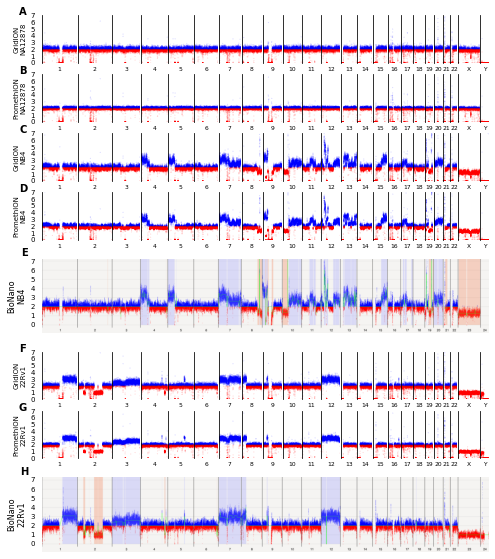

In [12]:
bin_size = 50_000
grid_ylab = "Copy number"
grid_ycol = "ploidy"
grid_ylim = (0, 8)
grid_fig_size = (8, 10)
xcol = "bin"
grid_file_ext = "pdf"
plot_kws = {"x": xcol, "y": grid_ycol, "marker": "."}

fig = plt.figure(figsize=grid_fig_size)
# Make the plot
fig.set_facecolor("white")
chrs = paf_to_targets_dict(files["barcode01"], remove="chrM")
# grid spec 5 rows, 1 column, height ratios (1.21) so the png fills the whole axis
gs0 = gridspec.GridSpec(8, 1, figure=fig, height_ratios=new_a)
gs0.tight_layout(fig)
gs_title_font_dict = {"fontsize": 10, "ha": "center", "weight": "semibold"}

# sub gridspecs for the 3 panels we are drawing from nanopore paf data
sub_gs_kwargs = {
    "ncols": len(chrs),
    "nrows": 1,
    "width_ratios": chrs.values(),
    "wspace": 0.025,
}

gs01 = gs0[0].subgridspec(**sub_gs_kwargs)
gs02 = gs0[1].subgridspec(**sub_gs_kwargs)
gs03 = gs0[2].subgridspec(**sub_gs_kwargs)
gs04 = gs0[3].subgridspec(**sub_gs_kwargs)
gs05 = gs0[5].subgridspec(**sub_gs_kwargs)
gs06 = gs0[6].subgridspec(**sub_gs_kwargs)

# create all 5 axes for our panels, 3 (1st, 2nd, 4th) are generators yielding
#   axes for each contig of nanopore data, 2 are single axes to put the PNG on
axs_1st = (fig.add_subplot(gs01[i]) for i in range(len(chrs)))
axs_2nd = (fig.add_subplot(gs02[i]) for i in range(len(chrs)))
axs_3rd = (fig.add_subplot(gs03[i]) for i in range(len(chrs)))
axs_4th = (fig.add_subplot(gs04[i]) for i in range(len(chrs)))
axs_5th = fig.add_subplot(gs0[4])
axs_6th = (fig.add_subplot(gs05[i]) for i in range(len(chrs)))
axs_7th = (fig.add_subplot(gs06[i]) for i in range(len(chrs)))
axs_8th = fig.add_subplot(gs0[7])

# progress bar
prog = tqdm(files.items(), dynamic_ncols=True)
nanopore_axes = (axs_1st, axs_2nd, axs_3rd, axs_4th, axs_6th, axs_7th)
bionano_axes = (axs_5th, axs_8th)
# PNGs from bionano browser
bionano_images = ("NB4_cropped_cnv.png", "22Rv1_cropped_cnv.png")
y_labels = {
    "barcode01": "GridION\nNA12878",
    "barcode02": "GridION\nNB4",
    "barcode03": "GridION\n22Rv1",
    "barcode05": "PromethION\nNA12878",
    "barcode06": "PromethION\nNB4",
    "barcode07": "PromethION\n22Rv1",
}
bionano_ylabels = dict(zip(bionano_images, ("BioNano\nNB4", "BioNano\n22Rv1")))
nanopore_panel_labels = iter("ABCDFG")
bionano_panel_labels = iter("EH")
# enumerate paf dfs
for j, (file, df) in enumerate(prog):
    # Create bins, aggregate data, normalise to expected copy
    df["bin"] = df["map_start"].floordiv(bin_size)
    plot_df = df.groupby(["target_name", "bin"], as_index=False).size()
    plot_df["ploidy"] = plot_df["size"] / plot_df["size"].median() * 2

    # Get targets for this PAF file
    chrs = paf_to_targets_dict(df, remove="chrM")

    for i, (ax, target) in enumerate(zip(nanopore_axes[j], chrs.keys())):
        target_length = chrs.get(target)
        assert target_length is not None, "This shouldn't happen"

        # Subset data
        tmpdf = plot_df[
            plot_df["target_name"].eq(target) & plot_df[grid_ycol].between(*grid_ylim)
        ]

        # Fill missing bins
        expected_min = 0
        expected_max = (target_length // bin_size) + 1
        # Create new index with all expected bins, apply that.
        #   See: https://stackoverflow.com/a/25916109
        new_index = pd.Index(np.arange(expected_min, expected_max, 1), name=xcol)
        tmpdf = tmpdf.set_index(xcol).reindex(new_index).reset_index()
        # These maybe unnecessary
        tmpdf["target_name"] = tmpdf["target_name"].fillna(target)
        tmpdf = tmpdf.fillna(0)

        # Generate colours array
        colors = (tmpdf[grid_ycol].gt(2)).map({True: "blue", False: "red"}).to_numpy()
        # Plot
        tmpdf.plot.scatter(c=colors, ax=ax, **plot_kws, s=0.01)
        ax.set_xmargin(0.01)

        # Despine
        for side in ["top", "bottom", "right"]:
            ax.spines[side].set_visible(False)
        # if not first col remove y axis labels
        if not ax.get_subplotspec().is_first_col():
            ax.yaxis.set_visible(False)
        else:
            label = y_labels.get(file)
            ax.set_ylabel(f"{label}", fontsize=7)
            add_panel_label(
                next(nanopore_panel_labels), gs_title_font_dict, ax, x_offset=-0.55
            )
        # fixed y lim for each contig axes
        ax.set_ylim(0, 7)
        # Remove x/y ticks
        ax.tick_params(bottom=False, left=False, labelbottom=False)
        target = target.lstrip("chr")
        ax.set_yticks(
            np.arange(
                min(ax.get_ylim()), max(ax.get_ylim()) + 1 / 7, (sum(ax.get_ylim())) / 7
            )
        )
        # force 0-7 on axes (mpl scaled down at this in steps of 2, 0-6 )
        ax.set_yticklabels(range(0, 8, 1), fontsize=7)
        ax.xaxis.set_label_text(target, fontdict={"fontsize": 6})

# now append bionano pngs
for ax, im in zip(bionano_axes, bionano_images):
    img = plt.imread(im)
    ax.imshow(img)
    # fully despine
    for side in ["top", "bottom", "right", "left"]:
        ax.spines[side].set_visible(False)
    # remove x/y ticks
    ax.tick_params(bottom=False, left=False, labelbottom=False)
    label = bionano_ylabels.get(im, "ahhhh")
    ax.set_ylabel(f"{label}", fontsize=8)
    # unintutively and wierdly going top down, set ticks so they match up with the png lines,
    #   done in something resembling pixels, eyeballometrically
    ax.set_yticks(
        np.arange(
            min(ax.get_ylim()) + 11,
            (max(ax.get_ylim()) - 30),
            (sum(ax.get_ylim()) - 45) / 7,
        )
    )
    ax.set_yticklabels(range(7, -1, -1), fontsize=7)
    add_panel_label(next(bionano_panel_labels), gs_title_font_dict, ax, x_offset=-0.04)
print("Drawing plot")
# fig.savefig(
#     f"Supplemental_Fig_S4.{grid_file_ext}",
#     dpi=300,
#     facecolor="w",
#     transparent=False,
#     bbox_inches="tight",
# )
# fig.savefig(
#     f"Supplemental_Fig_S4.pdf",
#     dpi=300,
#     facecolor="w",
#     transparent=False,
#     bbox_inches="tight",
# )

### FOr the Genome Research submission, we are inly focussing on the PromethION things


In [41]:
# Original height ratios
a = [1, 1.21, 1, 1.21]

# Calculate total height and proportions
sum_a = sum(a)
prop_3 = a[1] / sum_a
prop_5 = a[3] / sum_a

# Calculate new total height
sum_new_a = sum_a + 3

# Calculate new heights for 3rd and 5th rows
new_height_3 = prop_3 * sum_new_a
new_height_5 = prop_5 * sum_new_a

# New height ratios list
new_a = [1, new_height_3, 1, new_height_5]

print(new_a)

[1, 2.0312669683257916, 1, 2.0312669683257916]


  0%|                                                                                                         …

(<Axes: >, <Axes: >)
Drawing plot
0.08 0.88
0.08 0.758
0.08 0.632
0.08 0.502


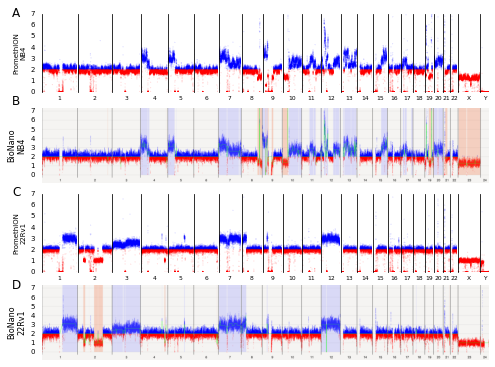

In [100]:
# progress bar
bin_size = 50_000
grid_ylab = "Copy number"
grid_ycol = "ploidy"
grid_ylim = (0, 8)
grid_fig_size = (8, 10)
xcol = "bin"
grid_file_ext = "pdf"
plot_kws = {"x": xcol, "y": grid_ycol, "marker": "."}

fig = plt.figure(figsize=grid_fig_size)
# Make the plot
fig.set_facecolor("white")
chrs = paf_to_targets_dict(files["barcode01"], remove="chrM")
# grid spec 5 rows, 1 column, height ratios (1.21) so the png fills the whole axis
gs0 = gridspec.GridSpec(len(new_a), 1, figure=fig, height_ratios=new_a)
gs0.tight_layout(fig)
gs_title_font_dict = {"fontsize": 10, "ha": "center", "weight": "medium"}

# sub gridspecs for the 3 panels we are drawing from nanopore paf data
sub_gs_kwargs = {
    "ncols": len(chrs),
    "nrows": 1,
    "width_ratios": chrs.values(),
    "wspace": 0.025,
}

barcodes = ["barcode06", "BNNB4", "barcode07", "BN22Rv1"]
gss = [
    gs0[i].subgridspec(**sub_gs_kwargs) if not i % 2 else gs0[i]
    for i, _ in enumerate(barcodes)
]

# create all 5 axes for our panels, 3 (1st, 2nd, 4th) are generators yielding
#   axes for each contig of nanopore data, 2 are single axes to put the PNG on
axes = [
    [fig.add_subplot(gs[i]) for i in range(len(chrs))]
    if not j % 2
    else fig.add_subplot(gs)
    for j, gs in enumerate(gss)
]
fig_files = [(k, v) for k, v in files.items() if k in barcodes[0::2]]
prog = tqdm(fig_files, dynamic_ncols=True)
nanopore_axes = tuple(axes[0::2])
bionano_axes = tuple(axes[1::2])
print(bionano_axes)
# PNGs from bionano browser
bionano_images = ("NB4_cropped_cnv.png", "22Rv1_cropped_cnv.png")
y_labels = {
    "barcode06": "PromethION\nNB4",
    "barcode07": "PromethION\n22Rv1",
}
bionano_ylabels = dict(zip(bionano_images, ("BioNano\nNB4", "BioNano\n22Rv1")))
nanopore_panel_labels = iter("AC")
bionano_panel_labels = iter("BD")
# enumerate paf dfs
for j, (file, df) in enumerate(prog):
    # Create bins, aggregate data, normalise to expected copy
    df["bin"] = df["map_start"].floordiv(bin_size)
    plot_df = df.groupby(["target_name", "bin"], as_index=False).size()
    plot_df["ploidy"] = plot_df["size"] / plot_df["size"].median() * 2

    # Get targets for this PAF file
    chrs = paf_to_targets_dict(df, remove="chrM")

    for i, (ax, target) in enumerate(zip(nanopore_axes[j], chrs.keys())):
        target_length = chrs.get(target)
        assert target_length is not None, "This shouldn't happen"

        # Subset data
        tmpdf = plot_df[
            plot_df["target_name"].eq(target) & plot_df[grid_ycol].between(*grid_ylim)
        ]

        # Fill missing bins
        expected_min = 0
        expected_max = (target_length // bin_size) + 1
        # Create new index with all expected bins, apply that.
        #   See: https://stackoverflow.com/a/25916109
        new_index = pd.Index(np.arange(expected_min, expected_max, 1), name=xcol)
        tmpdf = tmpdf.set_index(xcol).reindex(new_index).reset_index()
        # These maybe unnecessary
        tmpdf["target_name"] = tmpdf["target_name"].fillna(target)
        tmpdf = tmpdf.fillna(0)

        # Generate colours array
        colors = (tmpdf[grid_ycol].gt(2)).map({True: "blue", False: "red"}).to_numpy()
        # Plot
        tmpdf.plot.scatter(c=colors, ax=ax, **plot_kws, s=0.01)
        ax.set_xmargin(0.01)

        # Despine
        for side in ["top", "bottom", "right"]:
            ax.spines[side].set_visible(False)
        # if not first col remove y axis labels
        if not ax.get_subplotspec().is_first_col():
            ax.yaxis.set_visible(False)
        else:
            label = y_labels.get(file)
            ax.set_ylabel(f"{label}", fontsize=7)
        # fixed y lim for each contig axes
        ax.set_ylim(0, 7)
        # Remove x/y ticks
        ax.tick_params(bottom=False, left=False, labelbottom=False)
        target = target.lstrip("chr")
        ax.set_yticks(
            np.arange(
                min(ax.get_ylim()), max(ax.get_ylim()) + 1 / 7, (sum(ax.get_ylim())) / 7
            )
        )
        # force 0-7 on axes (mpl scaled down at this in steps of 2, 0-6 )
        ax.set_yticklabels(range(0, 8, 1), fontsize=7)
        ax.xaxis.set_label_text(target, fontdict={"fontsize": 6})

# now append bionano pngs
for ax, im in zip(bionano_axes, bionano_images):
    img = plt.imread(im)
    ax.imshow(img)
    # fully despine
    for side in ["top", "bottom", "right", "left"]:
        ax.spines[side].set_visible(False)
    # remove x/y ticks
    ax.tick_params(bottom=False, left=False, labelbottom=False)
    label = bionano_ylabels.get(im, "ahhhh")
    ax.set_ylabel(f"{label}", fontsize=8)
    # unintutively and wierdly going top down, set ticks so they match up with the png lines,
    #   done in something resembling pixels, eyeballometrically
    ax.set_yticks(
        np.arange(
            min(ax.get_ylim()) + 11,
            (max(ax.get_ylim()) - 30),
            (sum(ax.get_ylim()) - 45) / 7,
        )
    )
    ax.set_yticklabels(range(7, -1, -1), fontsize=7)
    # add_panel_label(next(bionano_panel_labels), gs_title_font_dict, ax, x_offset=-0.064)
for i, ax in chain(
    zip([2 for _ in range(len(nanopore_axes[1]))], nanopore_axes[1]),
    zip(range(1, len(bionano_axes) + 2, 2), bionano_axes),
):
    dy = 0.068
    # Manually adjust because the BioNano and ONT rows are actually different height
#     Pulls bottom 2 panels up slightly more, as there was a gap in the centre
    if i > 1:
        dy = 0.072
    pos = ax.get_position()
    new_pos = [
        pos.x0,
        pos.y0 + (dy * i),
        pos.width,
        pos.height,
    ]  # Move ax4 up by 0.05
    ax.set_position(new_pos)
print("Drawing plot")
start_x = 0.08
start_y = 0.88
dy = -0.122
for i, label in enumerate(iter("ABCD")):
    # Mnaually adjust because the BioNano and ONT rows are actually different height
    if i > 1:
        dy = -0.124
    if i > 2:
        dy = -0.126
    print(start_x, start_y + (dy * i))
    fig.text(start_x, start_y + (dy * i), label, ha="center", va="center", fontsize=12)
fig.savefig(
    f"Fig_S4_prom_only.png",
    dpi=300,
    facecolor="w",
    transparent=False,
    bbox_inches="tight",
)
fig.savefig(
    f"fig_s4_prom_only.pdf",
    dpi=300,
    facecolor="w",
    transparent=False,
    bbox_inches="tight",
)